# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 1: Healthcare Resource Allocation Modelling

Modelling a queuing system to model arriving patients (walk ins and prearranged appointments) and the allocation of four clinicians. We want to assess the efficiency of the system and identify causes of delays.

In [2]:
# this code is taken from labsheet 3

# Python Packages
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to generate inter-arrival times using an exponential distribution       
def generate_interarrival(lambda_rate):
    return np.random.exponential(1. / lambda_rate)

# Function to generate service times using an exponential distribution
def generate_service(mu_rate):
    return np.random.exponential(1. / mu_rate)

# Simulation function for the queuing system
def Simulation(env, servers):
    num_customers = 0                                           # Initialise a counter for the customers
    while True:                                                 # In this case, while the simulation is running
        yield env.timeout(generate_interarrival(lambda_rate))   # Yield until the next arrival, based on the interarrival time
        num_customers += 1                                      # Increment the customer number

        # When the customer arrives, start a new customer process
        env.process(Customer(env, num_customers, servers))

# Customer process function to simulate each customer's interaction with the server
def Customer(env, customer, servers):
    # Request a server from the pool of available servers
    with servers.request() as request:
        t_arrival = env.now  # Capture the arrival time of the customer

        # Track the number of customers currently in the system (both in service and in queue)
        in_systems.append((t_arrival, len(servers.queue) + len(servers.users)))
        
        # Log the customer arrival, including the number of customers 
        print(f'{env.now}: customer {customer} arrives.  Current number of people in the system: {len(servers.queue) + len(servers.users)}')       
       
        # Yield until the customer gets service (i.e., waits for a server to be available)
        yield request
        ##print(f'{env.now}: customer {customer} is being served')
        
        # Generate and wait for the service time (time spent being served)
        service_time = generate_service(mu_rate)
        yield env.timeout(service_time)
        
        # Customer departs after service
        t_depart = env.now  # Capture the departure time of the customer
        
        # Track the number of customers in the system after this customer departs
        in_systems.append((t_depart, len(servers.queue) + len(servers.users) - 1))
        
        # Log the customer departure, including the number of customers
        print(f'{env.now}: customer {customer} departs. Current number of people in the system: {len(servers.queue) + len(servers.users) - 1}')

        # Record the wait time and service time for the customer
        waits.append(t_depart - t_arrival)                      # Calculate the wait time (departure time - arrival time)
        service_t.append(service_time)                          # Record the service time
        service[customer] = service_time, t_depart - t_arrival  # Store service details for the customer




In [3]:
# Initialise lists to store results for wait times, service times, and system state
waits = [] # List to store wait times 
service_t = []  # list to store the service times for each customer
in_systems = [(0,0)] #list to track number of people at the given time
service={}

# Parameters 
lambda_rate = 5
mu_rate = 8
interarrival_time = 1/lambda_rate
service_time = 1/mu_rate

duration = 1000 #in minutes

# Create the simulation environment and server
env = simpy.Environment()
servers = simpy.Resource(env, capacity=4)  # initialise the servers (set to 1)
# Start the simulation
env.process(Simulation(env, servers))
# Run the simulation for a given time 
env.run(until=duration)


0.22977173352391334: customer 1 arrives.  Current number of people in the system: 1
0.2492554542343406: customer 1 departs. Current number of people in the system: 0
0.25049361546580934: customer 2 arrives.  Current number of people in the system: 1
0.26464761024479483: customer 2 departs. Current number of people in the system: 0
0.627166536360551: customer 3 arrives.  Current number of people in the system: 1
0.6756048147844381: customer 3 departs. Current number of people in the system: 0
0.7102846336586601: customer 4 arrives.  Current number of people in the system: 1
0.7327275827058572: customer 4 departs. Current number of people in the system: 0
1.1997038251200016: customer 5 arrives.  Current number of people in the system: 1
1.2076751664843548: customer 6 arrives.  Current number of people in the system: 2
1.2735075282357733: customer 6 departs. Current number of people in the system: 1
1.3072216462700297: customer 7 arrives.  Current number of people in the system: 2
1.37959

In [4]:
average_service_time = np.mean(service_t)  # Calculate the average customer service time
print(f'average customer service time: {average_service_time:.2f}')

W = np.mean(waits) # Calculate the average wait time across all customers
print(f' average customer wait time: {W:.2f}')

# Loop through the records of system states (time and queue length)
auc, last_t, last_l = 0, 0, 0
for t, l in in_systems:
    auc += (t-last_t)*last_l
    last_t, last_l = t, l
L=auc/last_t # Calculate the average number of customers in the system 
print(f' average number of customers in the system: {L:.2f}')

average customer service time: 0.13
 average customer wait time: 0.13
 average number of customers in the system: 0.64


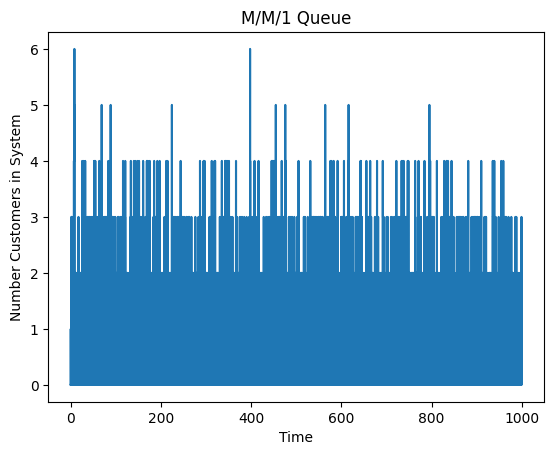

In [5]:
plt.step(*zip(*in_systems[:]), where='post')  # Plot the times of events (arrivals and departures) vs the number of customers at those times. 
plt.title("M/M/1 Queue")                        # Set the title of the plot
plt.xlabel("Time")                              # Label the x-axis as 'Time'
plt.ylabel("Number Customers in System")        # Label the y-axis as 'Number of Customers in System'
plt.show()                                      # Display the plot

I think a good approach would be to adapt this an object oriented program
We have customer objects with different properties and then we have functions to generate/process/exit them
We have clinicain classes which hold information about processing time and availability
A simulation class holds model statistics like total in system etc

Lets have a go at building those classes

Eek realised this is what Simpy does lol
Oop no they still use classes just don't need the simulation class

In [6]:
class Patient:
    def __init__(self, id, type, entry_time):
        self.id = id
        self.type = type
        self.entry_time = entry_time
        self.exit_time = 9999 # arbitrary high number. Gets updated when patient exits
    
    def __str__(self):
        return f"Patient:{self.id}(Type:{self.type}, Entry Time: {self.entry_time}, Exit Time: {self.entry_time})"

In [7]:
class Clincian:
    def __init__(self, id, service_time):
        self.id = id
        self.available = True
        self.service_time = service_time
        self.patient_tally = 0 # this counts how many the clinician has seen

    def __str__(self):
        return f"Patient:{self.id}(Availability Status:{self.available}, Service Time: {self.service_time}, Patient Tally: {self.patient_tally})"

In [8]:
# ok lets generate some patients

# appointment patients
appointment_times = np.arange(9,17,0.5) # every half hour 9-5! (HELLISH SCHEDULE)

# generate appointment patients